# GA

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Circle as MPLCircle
import random
from dataclasses import dataclass
from typing import List, Tuple, Optional
import copy
import os
import tarfile
from numba import jit, njit
import time

In [ ]:
def check_rectangle_in_circle(x_coords, y_coords, widths, heights, rotated_flags, radius_sq):
    """check if rectangles are completely inside circle"""
    n = len(x_coords)
    results = np.zeros(n, dtype=np.bool_)
    
    for i in range(n):
        # Get actual dimensions considering rotation
        w = heights[i] if rotated_flags[i] else widths[i]
        h = widths[i] if rotated_flags[i] else heights[i]
        
        half_w, half_h = w * 0.5, h * 0.5
        x, y = x_coords[i], y_coords[i]
        
        # Check all four corners
        corners_x = np.array([x - half_w, x - half_w, x + half_w, x + half_w])
        corners_y = np.array([y - half_h, y + half_h, y - half_h, y + half_h])
        
        distances_sq = corners_x**2 + corners_y**2
        results[i] = np.all(distances_sq <= radius_sq)
    
    return results

def check_overlap(rect_x, rect_y, rect_w, rect_h, other_x, other_y, other_w, other_h):
    """Check if rectangle overlaps with any"""
    half_w1, half_h1 = rect_w * 0.5, rect_h * 0.5
    left1, right1 = rect_x - half_w1, rect_x + half_w1
    bottom1, top1 = rect_y - half_h1, rect_y + half_h1
    
    n = len(other_x)
    for i in range(n):
        half_w2, half_h2 = other_w[i] * 0.5, other_h[i] * 0.5
        left2, right2 = other_x[i] - half_w2, other_x[i] + half_w2
        bottom2, top2 = other_y[i] - half_h2, other_y[i] + half_h2
        
        # Check overlap
        if not (right1 <= left2 or right2 <= left1 or top1 <= bottom2 or top2 <= bottom1):
            return True
    return False

def extract_solution_arrays(solution):
    """Extract numpy arrays from solution"""
    if not solution:
        return (np.array([]), np.array([]), np.array([]), 
                np.array([]), np.array([]), np.array([]))
    
    n = len(solution)
    x_coords = np.zeros(n)
    y_coords = np.zeros(n)
    widths = np.zeros(n)
    heights = np.zeros(n)
    rotated_flags = np.zeros(n, dtype=bool)
    values = np.zeros(n)
    
    for i, rect in enumerate(solution):
        x_coords[i] = rect.x
        y_coords[i] = rect.y
        widths[i] = rect.rect_type.width
        heights[i] = rect.rect_type.height
        rotated_flags[i] = rect.rotated
        values[i] = rect.value
    
    return x_coords, y_coords, widths, heights, rotated_flags, values

def generate_random_positions(n, radius):
    """Generate random positions within circle bounds"""
    x_coords = np.random.uniform(-radius, radius, n)
    y_coords = np.random.uniform(-radius, radius, n)
    return x_coords, y_coords

In [ ]:
@dataclass
class Rectangle:
    """Represents a rectangle type with its dimensions and value"""
    width: float
    height: float
    value: float
    
    def area(self):
        return self.width * self.height
    
    def can_fit_in_circle(self, radius):
        """Check if rectangle can fit in circle (diagonal <= diameter)"""
        diagonal = np.sqrt(self.width**2 + self.height**2)
        return diagonal <= 2 * radius

@dataclass
class PlacedRectangle:
    """Represents a placed rectangle with position and orientation"""
    rect_type: Rectangle
    x: float  # center x coordinate
    y: float  # center y coordinate
    rotated: bool = False  # True if 90 degrees rotated
    
    @property
    def width(self):
        return self.rect_type.height if self.rotated else self.rect_type.width
    
    @property
    def height(self):
        return self.rect_type.width if self.rotated else self.rect_type.height
    
    @property
    def value(self):
        return self.rect_type.value
    
    def get_bounds(self) -> Tuple[float, float, float, float]:
        """Returns (left, right, bottom, top) bounds"""
        half_w, half_h = self.width / 2, self.height / 2
        return (self.x - half_w, self.x + half_w, self.y - half_h, self.y + half_h)
    
    def is_inside_circle(self, radius: float) -> bool:
        """Check if rectangle is completely inside circle using numpy"""
        left, right, bottom, top = self.get_bounds()
        corners = np.array([[left, bottom], [left, top], [right, bottom], [right, top]])
        distances_sq = np.sum(corners**2, axis=1)
        return np.all(distances_sq <= radius**2)
    
    def overlaps_with(self, other: 'PlacedRectangle') -> bool:
        """Check if this rectangle overlaps with another"""
        left1, right1, bottom1, top1 = self.get_bounds()
        left2, right2, bottom2, top2 = other.get_bounds()
        
        return not (right1 <= left2 or right2 <= left1 or 
                   top1 <= bottom2 or top2 <= bottom1)

In [ ]:
class CirclePackingGA:
    def __init__(self, radius: float, rectangles: List[Rectangle], 
                 population_size: int = 100, max_generations: int = 1000,
                 mutation_rate: float = 0.1, crossover_rate: float = 0.8,
                 max_rectangles: int = 50):
        self.radius = radius
        self.radius_sq = radius * radius
        self.rectangles = rectangles
        self.population_size = population_size
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.max_rectangles = max_rectangles
        
        # Filter rectangles that can potentially fit
        self.valid_rectangles = [r for r in rectangles if r.can_fit_in_circle(radius)]
        
        self.n_rect_types = len(self.valid_rectangles)
        self.rect_widths = np.array([r.width for r in self.valid_rectangles])
        self.rect_heights = np.array([r.height for r in self.valid_rectangles])
        self.rect_values = np.array([r.value for r in self.valid_rectangles])
        
        self.population = []
        self.best_solution = None
        self.best_fitness = 0
        self.fitness_history = []
        
        self.fitness_cache = {}
    
    def create_random_individual(self):
        """Create a random individual"""
        individual = []
        max_attempts = 150
        target_size = random.randint(5, min(self.max_rectangles, 40))
        
        for _ in range(target_size):
            attempts = 0
            while attempts < max_attempts:
                # Choose random rectangle type
                rect_idx = random.randint(0, self.n_rect_types - 1)
                rect_type = self.valid_rectangles[rect_idx]
                
                # Random position and rotation
                x = random.uniform(-self.radius, self.radius)
                y = random.uniform(-self.radius, self.radius)
                rotated = random.choice([True, False])
                
                placed_rect = PlacedRectangle(rect_type, x, y, rotated)
                
                # Fast validity check using vectorized operations
                if self._is_valid_placement(placed_rect, individual):
                    individual.append(placed_rect)
                    break
                
                attempts += 1
        
        return individual
    
    def _is_valid_placement(self, rect: PlacedRectangle, existing: List[PlacedRectangle]):
        """validity check"""
        # Check circle containment
        if not rect.is_inside_circle(self.radius):
            return False
        
        if not existing:
            return True
        # Extract arrays and check overlaps vectorized
        x_arr, y_arr, w_arr, h_arr, rot_arr, _ = extract_solution_arrays(existing)
        
        # Get actual dimensions considering rotation
        actual_widths = np.where(rot_arr, h_arr, w_arr)
        actual_heights = np.where(rot_arr, w_arr, h_arr)
        
        rect_w = rect.height if rect.rotated else rect.width
        rect_h = rect.width if rect.rotated else rect.height
        
        return not check_overlap(rect.x, rect.y, rect_w, rect_h,
                                     x_arr, y_arr, actual_widths, actual_heights)
    
    def calculate_fitness(self, individual: List[PlacedRectangle]):
        """fitness calculation"""
        if not individual:
            return 0.0
        
        ind_hash = hash(tuple((r.x, r.y, r.rotated, id(r.rect_type)) for r in individual))
        if ind_hash in self.fitness_cache:
            return self.fitness_cache[ind_hash]
        
        # Extract arrays
        x_coords, y_coords, widths, heights, rotated_flags, values = extract_solution_arrays(individual)
        
        # Check circle containment for all rectangles
        valid_in_circle = check_rectangle_in_circle(
            x_coords, y_coords, widths, heights, rotated_flags, self.radius_sq)
        
        # Check overlaps
        valid_placements = np.zeros(len(individual), dtype=bool)
        actual_widths = np.where(rotated_flags, heights, widths)
        actual_heights = np.where(rotated_flags, widths, heights)
        
        # Process rectangles that are inside circle
        for i in range(len(individual)):
            if not valid_in_circle[i]:
                continue
            
            if i == 0:
                valid_placements[i] = True
            else:
                # Check overlap with previously validated rectangles
                prev_valid_indices = np.where(valid_placements[:i])[0]
                if len(prev_valid_indices) == 0:
                    valid_placements[i] = True
                else:
                    has_overlap = check_overlap(
                        x_coords[i], y_coords[i], actual_widths[i], actual_heights[i],
                        x_coords[prev_valid_indices], y_coords[prev_valid_indices],
                        actual_widths[prev_valid_indices], actual_heights[prev_valid_indices]
                    )
                    valid_placements[i] = not has_overlap
        
        # Calculate total value
        fitness = float(np.sum(values[valid_placements]))
        self.fitness_cache[ind_hash] = fitness
        return fitness
    
    def tournament_selection(self, tournament_size: int = 3):
        tournament_indices = np.random.choice(len(self.population), tournament_size, replace=False)
        tournament_fitness = [self.calculate_fitness(self.population[i]) for i in tournament_indices]
        best_idx = tournament_indices[np.argmax(tournament_fitness)]
        return self.population[best_idx]
    
    def crossover(self, parent1: List[PlacedRectangle], 
                  parent2: List[PlacedRectangle]):
        if random.random() > self.crossover_rate:
            return copy.deepcopy(parent1), copy.deepcopy(parent2)
        
        if not parent1 or not parent2:
            return copy.deepcopy(parent1), copy.deepcopy(parent2)
        
        cut_point = random.randint(1, min(len(parent1), len(parent2)))
        
        child1 = copy.deepcopy(parent1[:cut_point])
        child2 = copy.deepcopy(parent2[:cut_point])
        
        # Try to add rectangles from second parent
        for rect in parent2[cut_point:]:
            new_rect = copy.deepcopy(rect)
            if self._is_valid_placement(new_rect, child1):
                child1.append(new_rect)
        
        for rect in parent1[cut_point:]:
            new_rect = copy.deepcopy(rect)
            if self._is_valid_placement(new_rect, child2):
                child2.append(new_rect)
        
        return child1, child2
    
    def mutate(self, individual: List[PlacedRectangle]):
        if random.random() > self.mutation_rate:
            return individual
        
        individual = copy.deepcopy(individual)
        
        mutation_type = random.choice(['add', 'remove', 'move', 'rotate', 'replace'])
        
        if mutation_type == 'add' and len(individual) < self.max_rectangles:
            # Generate candidate positions
            n_candidates = 25
            rect_idx = random.randint(0, self.n_rect_types - 1)
            rect_type = self.valid_rectangles[rect_idx]
            
            x_candidates, y_candidates = generate_random_positions(n_candidates, self.radius)
            rotations = np.random.choice([True, False], n_candidates)
            
            for i in range(n_candidates):
                new_rect = PlacedRectangle(rect_type, x_candidates[i], y_candidates[i], rotations[i])
                if self._is_valid_placement(new_rect, individual):
                    individual.append(new_rect)
                    break
        
        elif mutation_type == 'remove' and individual:
            individual.pop(random.randint(0, len(individual) - 1))
        
        elif mutation_type == 'move' and individual:
            idx = random.randint(0, len(individual) - 1)
            rect = individual[idx]
            
            n_candidates = 20
            x_candidates, y_candidates = generate_random_positions(n_candidates, self.radius)
            
            temp_individual = individual[:idx] + individual[idx+1:]
            
            for i in range(n_candidates):
                new_rect = PlacedRectangle(rect.rect_type, x_candidates[i], y_candidates[i], rect.rotated)
                if self._is_valid_placement(new_rect, temp_individual):
                    individual[idx] = new_rect
                    break
        
        elif mutation_type == 'rotate' and individual:
            idx = random.randint(0, len(individual) - 1)
            rect = individual[idx]
            
            new_rect = PlacedRectangle(rect.rect_type, rect.x, rect.y, not rect.rotated)
            temp_individual = individual[:idx] + individual[idx+1:]
            
            if self._is_valid_placement(new_rect, temp_individual):
                individual[idx] = new_rect
        
        elif mutation_type == 'replace' and individual:
            idx = random.randint(0, len(individual) - 1)
            rect = individual[idx]
            
            new_rect_idx = random.randint(0, self.n_rect_types - 1)
            new_rect_type = self.valid_rectangles[new_rect_idx]
            new_rect = PlacedRectangle(new_rect_type, rect.x, rect.y, rect.rotated)
            
            temp_individual = individual[:idx] + individual[idx+1:]
            if self._is_valid_placement(new_rect, temp_individual):
                individual[idx] = new_rect
        
        return individual
    
    def evolve(self):
        """Main evolution loop with performance monitoring"""
        start_time = time.time()
        
        # Initialize population
        print("Initializing population...")
        self.population = [self.create_random_individual() for _ in range(self.population_size)]
        
        for generation in range(self.max_generations):
            # Calculate fitness for all individuals
            fitness_scores = np.array([self.calculate_fitness(ind) for ind in self.population])
            
            # Track best solution
            best_idx = np.argmax(fitness_scores)
            if fitness_scores[best_idx] > self.best_fitness:
                self.best_fitness = fitness_scores[best_idx]
                self.best_solution = copy.deepcopy(self.population[best_idx])
            
            self.fitness_history.append(np.max(fitness_scores))
            
            # Print progress
            if generation % 50 == 0:
                avg_fitness = np.mean(fitness_scores)
                elapsed = time.time() - start_time
                print(f"Gen {generation:3d}: Best={self.best_fitness:7.0f}, Avg={avg_fitness:7.1f}, "
                      f"Time={elapsed:.1f}s")
            
            # Create new population
            new_population = []
            
            # Elitism: keep best individual
            new_population.append(copy.deepcopy(self.best_solution))
            
            # Generate rest of population
            while len(new_population) < self.population_size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()
                
                child1, child2 = self.crossover(parent1, parent2)
                
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                
                new_population.extend([child1, child2])
            
            self.population = new_population[:self.population_size]
            
            # Clear cache periodically to prevent memory issues
            if generation % 100 == 0 and len(self.fitness_cache) > 1000:
                self.fitness_cache.clear()
        
        total_time = time.time() - start_time
        print(f"\nEvolution completed in {total_time:.2f} seconds")
        print(f"Final best fitness: {self.best_fitness}")
        return self.best_solution, self.best_fitness

## Visualization Functions

In [77]:
def visualize_solution(solution: List[PlacedRectangle], radius: float, title: str = "Solution"):
    """Visualize the packing solution"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # Draw circle
    circle = MPLCircle((0, 0), radius, fill=False, edgecolor='black', linewidth=2)
    ax.add_patch(circle)
    
    # Color map for different rectangle values
    colors = plt.cm.Set3(np.linspace(0, 1, len(set(rect.value for rect in solution))))
    value_to_color = {value: color for value, color in 
                     zip(sorted(set(rect.value for rect in solution)), colors)}
    
    total_value = 0
    
    # Draw rectangles
    for rect in solution:
        left, right, bottom, top = rect.get_bounds()
        width = right - left
        height = top - bottom
        
        rectangle = patches.Rectangle(
            (left, bottom), width, height,
            linewidth=1, edgecolor='black',
            facecolor=value_to_color.get(rect.value, 'lightblue'),
            alpha=0.7
        )
        ax.add_patch(rectangle)
        
        # Add value text
        ax.text(rect.x, rect.y, f'{rect.value}', 
               ha='center', va='center', fontsize=8, weight='bold')
        
        total_value += rect.value
    
    ax.set_xlim(-radius * 1.1, radius * 1.1)
    ax.set_ylim(-radius * 1.1, radius * 1.1)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(f'{title}\nTotal Value: {total_value}, Rectangles: {len(solution)}')
    
    plt.tight_layout()
    plt.show()
    
    return total_value

def plot_fitness_history(fitness_history: List[float]):
    """Plot fitness evolution over generations"""
    plt.figure(figsize=(10, 6))
    plt.plot(fitness_history)
    plt.title('Fitness Evolution Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.grid(True, alpha=0.3)

## Data Loading and Testing

In [ ]:
def load_rectangle_data(filepath: str):
    """Load rectangle data from CSV file"""
    # Extract radius from filename
    filename = os.path.basename(filepath)
    radius = float(filename.split('r')[1].split('.')[0])
    
    # Load rectangles
    df = pd.read_csv(filepath, header=None, names=['width', 'height', 'value'])
    rectangles = [Rectangle(row['width'], row['height'], row['value']) 
                 for _, row in df.iterrows()]
    
    return radius, rectangles

def extract_data_files(tar_path: str, extract_to: str = './data'):
    """Extract data files from tar archive"""
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    
    with tarfile.open(tar_path, 'r:xz') as tar:
        tar.extractall(extract_to)
    
    return extract_to

# Function to test on all datasets
def test_all_datasets(data_directory: str):
    """Test the algorithm on all datasets with performance monitoring"""
    results = {}
    
    csv_files = [f for f in os.listdir(data_directory) if f.endswith('.csv')]
    
    for filename in sorted(csv_files):
        filepath = os.path.join(data_directory, filename)
        radius, rectangles = load_rectangle_data(filepath)
        
        print(f"\n{'='*60}")
        print(f"Testing on {filename} (radius: {radius})")
        print(f"Available rectangle types: {len(rectangles)}")
        
        # Show some statistics
        df = pd.DataFrame([(r.width, r.height, r.value, r.area()) for r in rectangles],
                         columns=['width', 'height', 'value', 'area'])
        print(f"Value range: {df['value'].min():.0f} - {df['value'].max():.0f}")
        print(f"Area range: {df['area'].min():.1f} - {df['area'].max():.1f}")
        
        # Run optimized genetic algorithm
        start_time = time.time()
        ga = CirclePackingGA(
            radius=radius,
            rectangles=rectangles,
            population_size=200,
            max_generations=1000,
            mutation_rate=0.15,
            crossover_rate=0.8,
            max_rectangles=120
        )
        
        best_solution, best_fitness = ga.evolve()
        elapsed_time = time.time() - start_time
        
        results[filename] = {
            'radius': radius,
            'best_fitness': best_fitness,
            'solution': best_solution,
            'fitness_history': ga.fitness_history,
            'execution_time': elapsed_time
        }
        
        print(f"Total execution time: {elapsed_time:.2f} seconds")
        
        # Visualize solution
        visualize_solution(best_solution, radius, f"Optimized Solution for {filename}")
        plot_fitness_history(ga.fitness_history)
    
    return results

# Results

Running tests on all datasets...

Testing on r1000.csv (radius: 1000.0)
Available rectangle types: 4
Value range: 40 - 500
Area range: 12000.0 - 40000.0
Initializing population...
Gen   0: Best=   9240, Avg= 4842.3, Time=0.6s
Gen  50: Best=  14000, Avg=13259.8, Time=17.9s
Gen 100: Best=  16940, Avg=16729.1, Time=41.8s
Gen 150: Best=  18240, Avg=18186.6, Time=72.7s
Gen 200: Best=  18880, Avg=18823.5, Time=106.9s
Gen 250: Best=  19380, Avg=19325.9, Time=144.3s
Gen 300: Best=  19500, Avg=19484.8, Time=184.9s
Gen 350: Best=  19580, Avg=19565.8, Time=227.1s
Gen 400: Best=  19820, Avg=19771.4, Time=271.7s
Gen 450: Best=  19860, Avg=19845.9, Time=317.2s
Gen 500: Best=  19860, Avg=19843.1, Time=363.6s
Gen 550: Best=  19860, Avg=19850.6, Time=410.8s
Gen 600: Best=  19900, Avg=19880.7, Time=458.1s
Gen 650: Best=  19900, Avg=19884.2, Time=505.6s
Gen 700: Best=  19900, Avg=19892.0, Time=552.6s
Gen 750: Best=  19900, Avg=19883.0, Time=600.0s
Gen 800: Best=  19900, Avg=19891.8, Time=647.3s
Gen 850: 

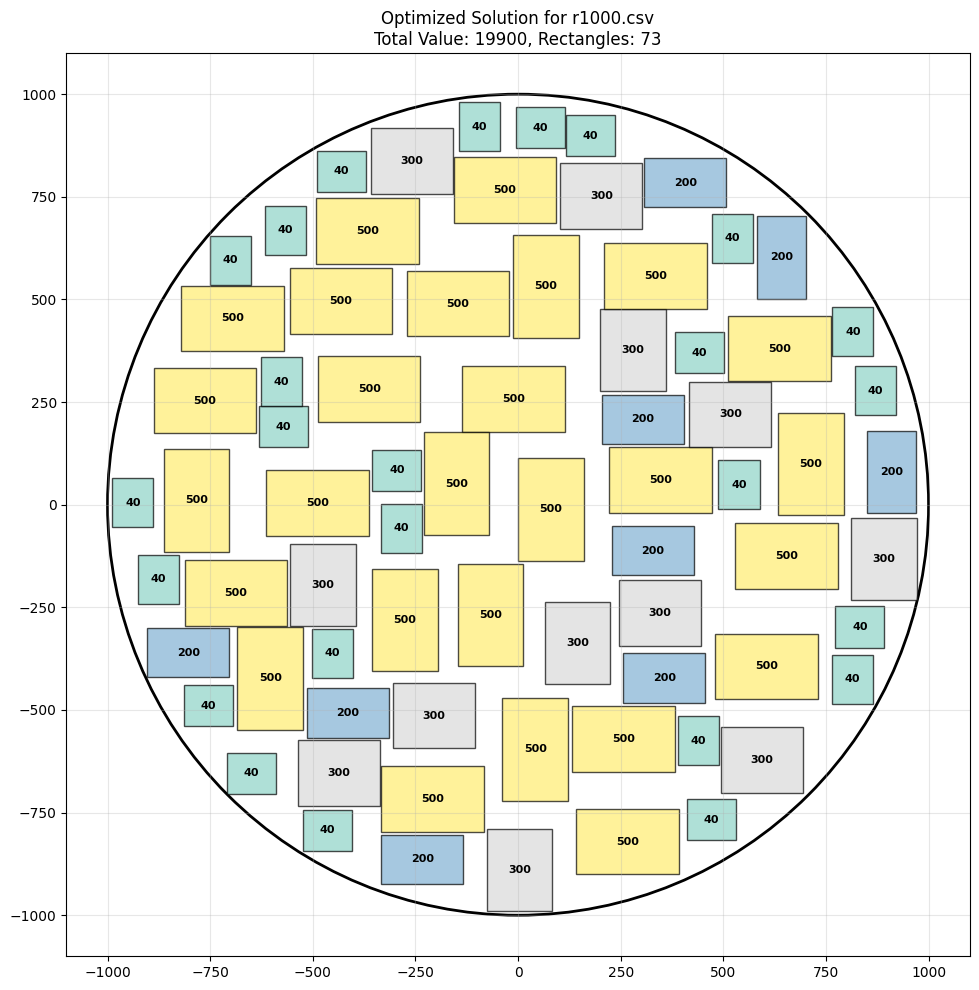


Testing on r1100.csv (radius: 1100.0)
Available rectangle types: 4
Value range: 40 - 600
Area range: 18000.0 - 43200.0
Initializing population...
Gen   0: Best=  11040, Avg= 4767.5, Time=0.5s
Gen  50: Best=  18380, Avg=17504.4, Time=16.1s
Gen 100: Best=  22520, Avg=22218.6, Time=37.8s
Gen 150: Best=  23480, Avg=23418.7, Time=65.6s
Gen 200: Best=  24340, Avg=24324.9, Time=99.1s
Gen 250: Best=  24560, Avg=24532.5, Time=136.0s
Gen 300: Best=  24600, Avg=24587.2, Time=175.8s
Gen 350: Best=  24720, Avg=24706.2, Time=216.5s
Gen 400: Best=  24800, Avg=24770.1, Time=259.4s
Gen 450: Best=  24800, Avg=24778.8, Time=302.0s
Gen 500: Best=  24900, Avg=24842.5, Time=345.2s
Gen 550: Best=  24900, Avg=24881.8, Time=389.7s
Gen 600: Best=  24940, Avg=24915.9, Time=433.8s
Gen 650: Best=  25000, Avg=24924.1, Time=479.3s
Gen 700: Best=  25000, Avg=24974.0, Time=524.3s
Gen 750: Best=  25000, Avg=24983.0, Time=569.6s
Gen 800: Best=  25000, Avg=24991.0, Time=614.6s
Gen 850: Best=  25000, Avg=24992.2, Time=65

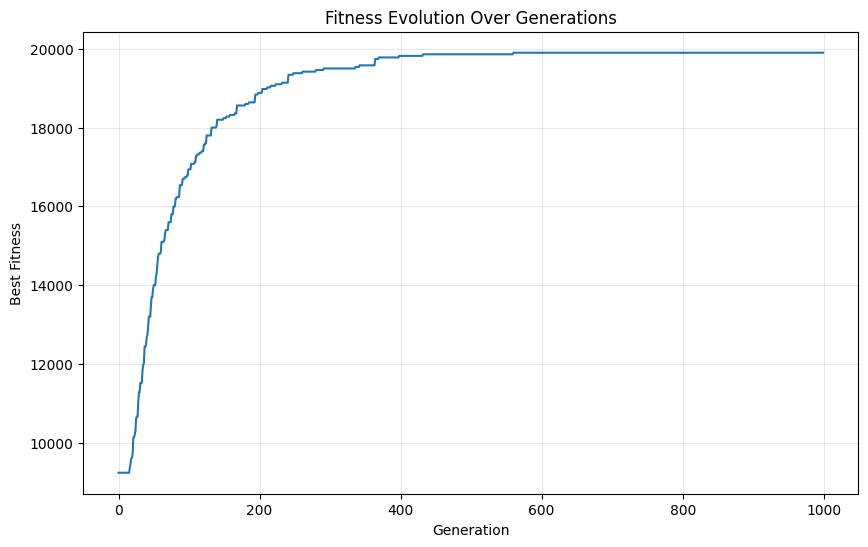

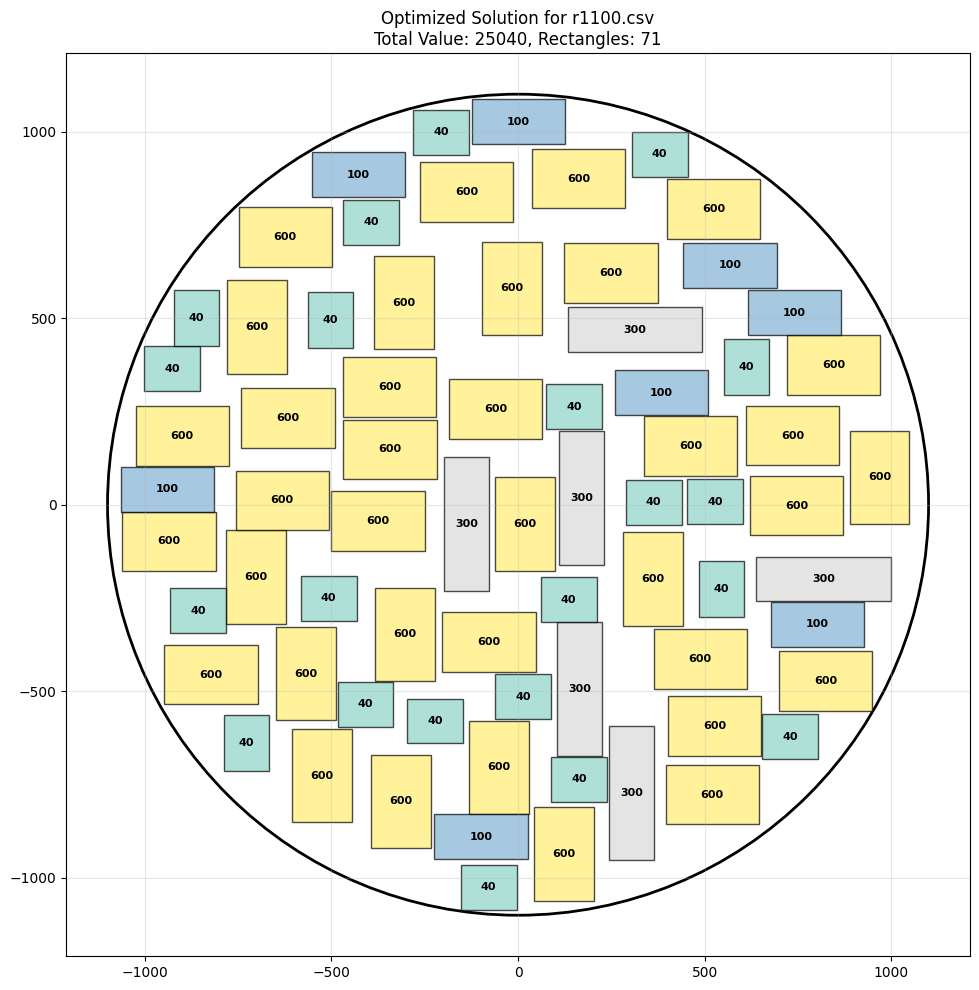


Testing on r1200.csv (radius: 1200.0)
Available rectangle types: 4
Value range: 40 - 500
Area range: 12000.0 - 40000.0
Initializing population...
Gen   0: Best=  10680, Avg= 5320.9, Time=0.3s
Gen  50: Best=  16820, Avg=16171.7, Time=21.4s
Gen 100: Best=  22740, Avg=22378.8, Time=50.9s
Gen 150: Best=  26220, Avg=25932.1, Time=89.1s
Gen 200: Best=  27620, Avg=27568.0, Time=134.9s
Gen 250: Best=  27860, Avg=27841.3, Time=186.8s
Gen 300: Best=  28240, Avg=28129.8, Time=245.4s
Gen 350: Best=  28560, Avg=28516.9, Time=308.5s
Gen 400: Best=  28760, Avg=28443.4, Time=373.0s
Gen 450: Best=  28980, Avg=28437.0, Time=436.1s
Gen 500: Best=  28980, Avg=28628.1, Time=498.4s
Gen 550: Best=  28980, Avg=28591.1, Time=560.6s
Gen 600: Best=  28980, Avg=28562.2, Time=622.9s
Gen 650: Best=  29140, Avg=28754.8, Time=685.6s
Gen 700: Best=  29300, Avg=28977.7, Time=749.2s
Gen 750: Best=  29300, Avg=28917.7, Time=812.4s
Gen 800: Best=  29300, Avg=28902.8, Time=875.2s
Gen 850: Best=  29300, Avg=28905.8, Time=9

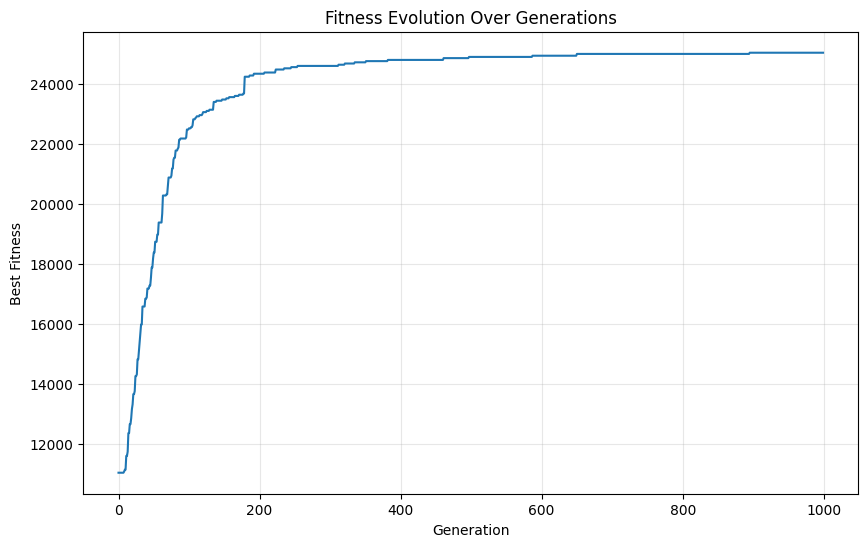

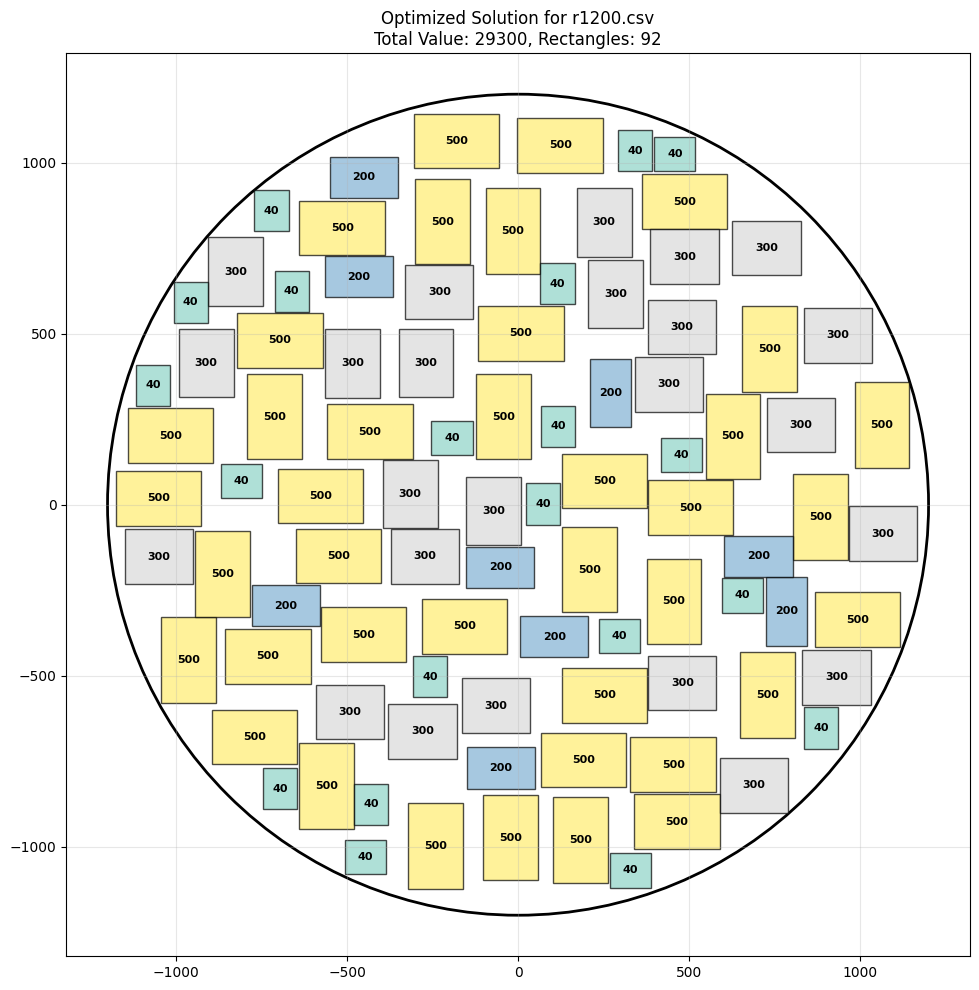


Testing on r800.csv (radius: 800.0)
Available rectangle types: 5
Value range: 40 - 600
Area range: 12000.0 - 51200.0
Initializing population...
Gen   0: Best=   8800, Avg= 4609.1, Time=1.9s
Gen  50: Best=  11280, Avg=11170.8, Time=18.2s
Gen 100: Best=  13320, Avg=13041.2, Time=39.9s
Gen 150: Best=  14160, Avg=14129.1, Time=64.2s
Gen 200: Best=  14200, Avg=14159.1, Time=90.0s
Gen 250: Best=  14640, Avg=14632.0, Time=116.3s
Gen 300: Best=  14640, Avg=14628.1, Time=142.8s
Gen 350: Best=  14640, Avg=14617.3, Time=169.7s
Gen 400: Best=  14640, Avg=14612.1, Time=196.5s
Gen 450: Best=  14640, Avg=14623.0, Time=223.2s
Gen 500: Best=  14640, Avg=14622.5, Time=250.0s
Gen 550: Best=  15040, Avg=15027.7, Time=277.8s
Gen 600: Best=  15440, Avg=15428.5, Time=305.6s
Gen 650: Best=  15440, Avg=15415.3, Time=334.1s
Gen 700: Best=  15440, Avg=15405.6, Time=362.1s
Gen 750: Best=  15440, Avg=15429.8, Time=390.2s
Gen 800: Best=  15440, Avg=15414.3, Time=418.5s
Gen 850: Best=  15440, Avg=15415.8, Time=446.

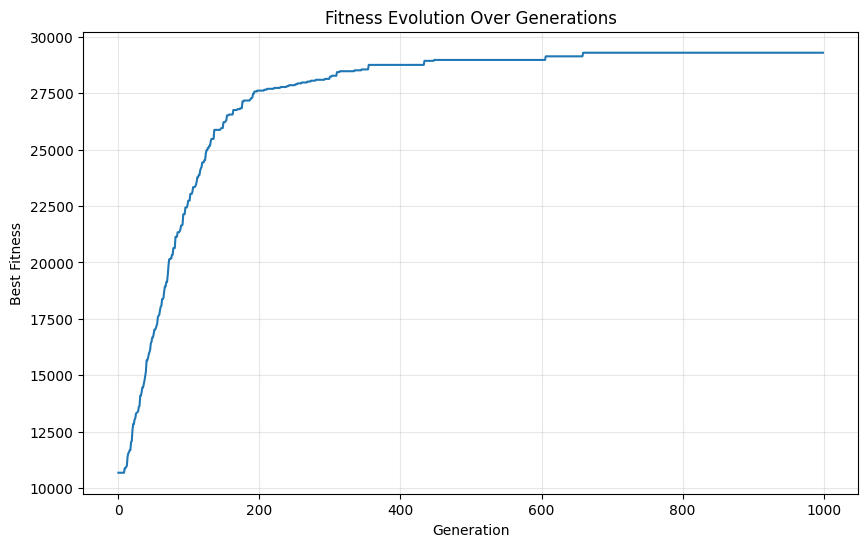

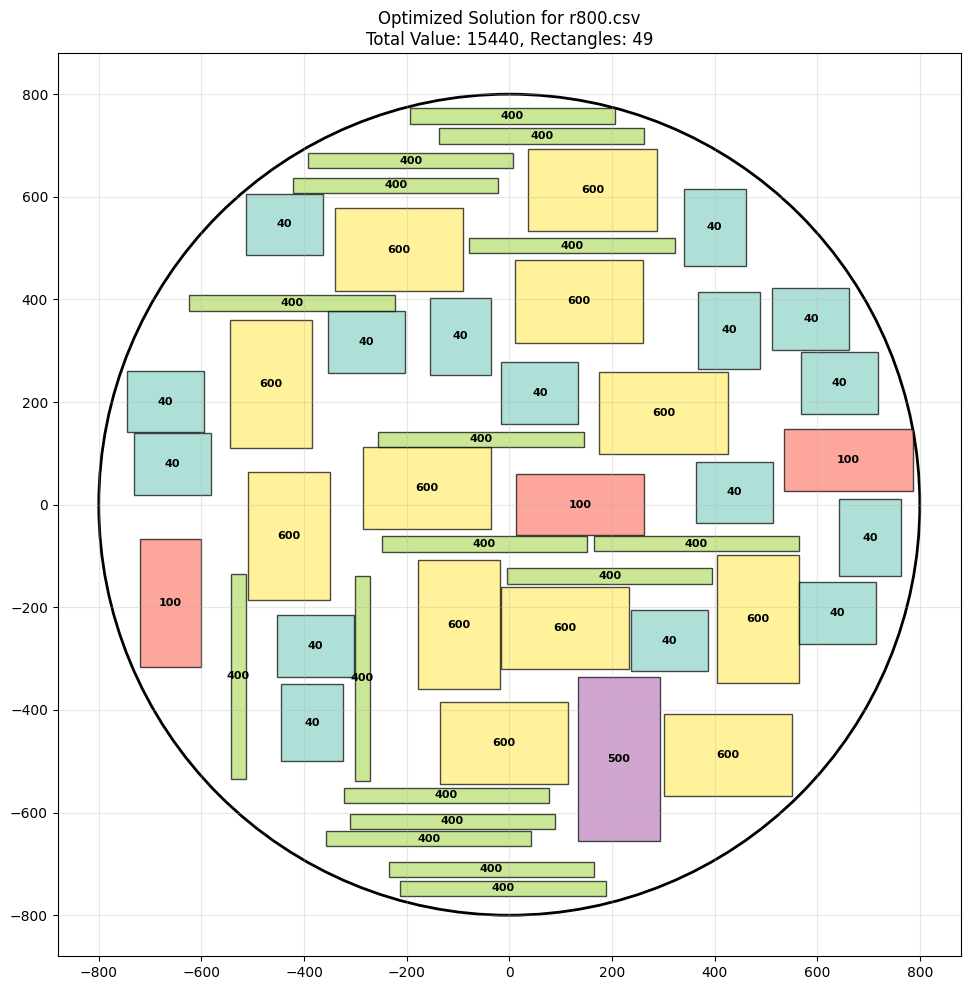


Testing on r850.csv (radius: 850.0)
Available rectangle types: 7
Value range: 120 - 11000
Area range: 1200.0 - 36000.0
Initializing population...
Gen   0: Best=  80020, Avg=26599.8, Time=0.3s
Gen  50: Best= 199420, Avg=196663.6, Time=14.2s
Gen 100: Best= 235070, Avg=233440.4, Time=34.2s
Gen 150: Best= 250850, Avg=249106.1, Time=62.7s
Gen 200: Best= 258590, Avg=258232.0, Time=98.7s
Gen 250: Best= 267830, Avg=266696.2, Time=142.8s
Gen 300: Best= 273590, Avg=273106.1, Time=196.5s
Gen 350: Best= 277790, Avg=277661.4, Time=258.6s
Gen 400: Best= 280280, Avg=279144.3, Time=329.5s
Gen 450: Best= 282650, Avg=282331.0, Time=411.1s
Gen 500: Best= 283520, Avg=283089.0, Time=500.3s
Gen 550: Best= 283550, Avg=283370.9, Time=591.8s
Gen 600: Best= 283550, Avg=283521.7, Time=682.5s
Gen 650: Best= 283550, Avg=283419.3, Time=773.0s
Gen 700: Best= 283550, Avg=283471.9, Time=863.6s
Gen 750: Best= 283550, Avg=283477.5, Time=954.7s
Gen 800: Best= 283550, Avg=283355.0, Time=1046.0s
Gen 850: Best= 283640, Avg

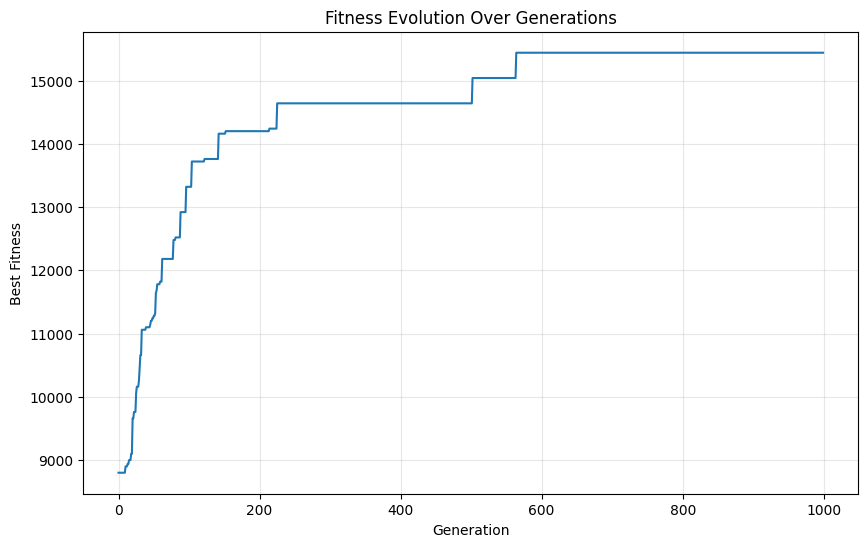

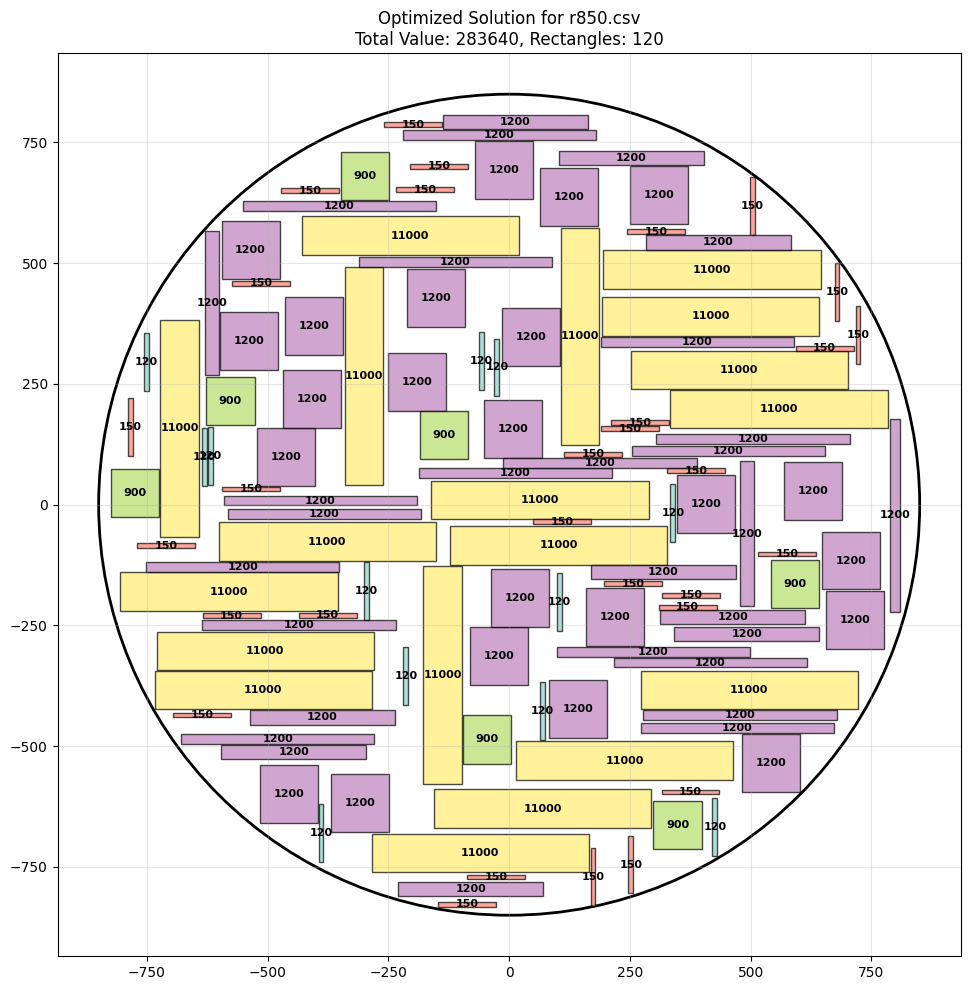


SUMMARY OF RESULTS
r1000.csv       (r=1000):    19900
r1100.csv       (r=1100):    25040
r1200.csv       (r=1200):    29300
r800.csv        (r=800 ):    15440
r850.csv        (r=850 ):   283640

MINIMUM REQUIREMENTS CHECK:
r=1000.0:    19900 (required: 17500) ✓ PASS
r=1100.0:    25040 (required: 25000) ✓ PASS
r=1200.0:    29300 (required: 30000) ✗ FAIL
r=800.0:    15440 (required: 30000) ✗ FAIL


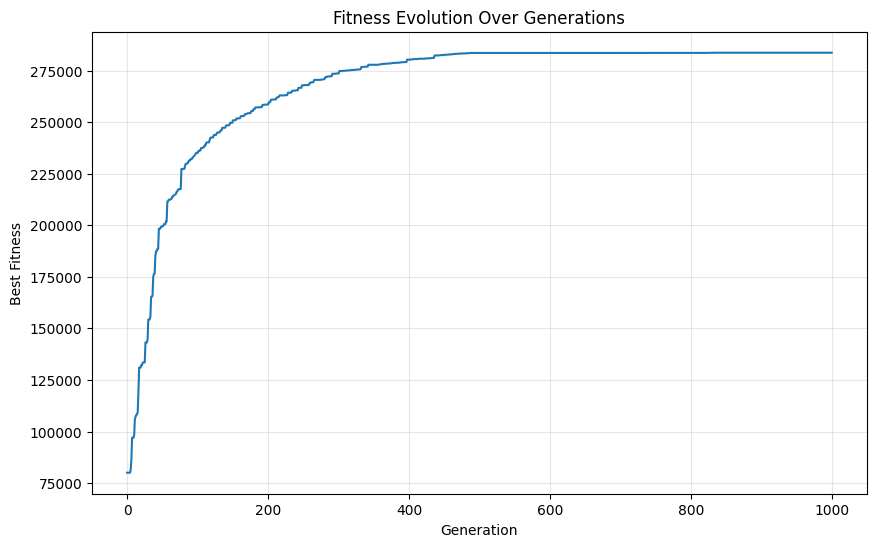

In [ ]:
data_path = "data/cutting"

if os.path.exists(data_path):
    print("Running tests on all datasets...")
    results = test_all_datasets('data/cutting/')
    
    # Summary of results
    print("\n" + "="*60)
    print("SUMMARY OF RESULTS")
    print("="*60)
    
    for filename, result in results.items():
        radius = result['radius']
        fitness = result['best_fitness']
        print(f"{filename:<15} (r={radius:<4.0f}): {fitness:>8.0f}")
    
    # Check against minimum requirements
    requirements = {
        800: 30000,
        1000: 17500,
        1100: 25000,
        1200: 30000
    }
    
    print("\nMINIMUM REQUIREMENTS CHECK:")
    for filename, result in results.items():
        radius = result['radius']
        fitness = result['best_fitness']
        if radius in requirements:
            required = requirements[radius]
            status = "✓ PASS" if fitness >= required else "✗ FAIL"
            print(f"r={radius}: {fitness:>8.0f} (required: {required}) {status}")

else:
    print(f"Data file not found: {data_path}")
    print("Please provide the cutting.tar.xz file to test with real data.")